# Fitbit Analysis Project
I want to start doing little project of my personal data tracked by fitbit charge 4 to see the insight of it as well as to uncover any hidden and interesting findings along the way.

## 1. Getting Data
Go get data from fitbit.com

## 2. Importing important libraries
Importing libralies to do analysis.

In [1]:
import matplotlib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt # default library for making plots
import seaborn as sns # for making prettier plots!
import datetime as dt
import math
import datetime

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # to see all columns in the pd dataframe
%config InlineBackend.figure_format = 'retina' # for the crispier version of plots for retina screens

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

## 3. Importing the Dataset

In [2]:
data = pd.read_excel('fitbit_data.xlsx', converters= {'Date': pd.to_datetime})
data.set_index(pd.to_datetime(data.Date),inplace=True)
data.head()

,Date,Day of week,Is weekday,Is weekend,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Sleep Start Time,Sleep End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Nap,% REM sleep,% Light sleep,% Deep sleep
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-14,2021-11-14,7,False,True,1654,5930,3.89,5,740,184,7,7,579,14/11/2021 02:06:00,14/11/2021 10:28:00,451,51,35,502,142,256,53,0,0.282869,0.509960,0.105578
2021-11-15,2021-11-15,1,True,False,1418,1416,0.94,0,822,96,0,0,239,15/11/2021 00:19:00,15/11/2021 09:01:00,469,53,56,522,155,205,109,0,0.296935,0.392720,0.208812
2021-11-16,2021-11-16,2,True,False,1466,2512,1.65,0,826,129,0,0,329,16/11/2021 01:09:00,16/11/2021 09:14:00,419,66,40,485,88,265,66,0,0.181443,0.546392,0.136082
2021-11-17,2021-11-17,3,True,False,1365,1583,1.01,0,791,85,0,0,206,16/11/2021 23:39:00,17/11/2021 09:03:00,517,47,52,564,167,228,122,0,0.296099,0.404255,0.216312
2021-11-18,2021-11-18,4,True,False,1432,1183,0.79,0,534,130,0,0,315,18/11/2021 00:27:00,18/11/2021 11:52:00,584,101,50,685,136,338,110,111,0.198540,0.493431,0.160584


## 4. Building new columns and sanitising the data
Firstly we will be removing the activity where there were no steps recorded. For sleep data, we will clear out rows where there was no "Deep Sleep" entries.

In [3]:
dayCodes = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
minDayCodes = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def is_nan(x):
    return (x is np.nan or x != x)

def defineSleepBucket(row):
    sleepEntry = row['Sleep Start Time']
    if not is_nan(sleepEntry):
        sleepTimeO = datetime.datetime.strptime(sleepEntry, '%d/%m/%Y %H:%M:%S').time()        
        if sleepTimeO.minute > 30:
            return (sleepTimeO.hour + 1)
            #return '{}:{}'.format(str((sleepTimeO.hour + 1)), '00')
        elif sleepTimeO.minute > 0:
            return sleepTimeO.hour + 0.5
            #return '{}:{}'.format(str(sleepTimeO.hour), ':30')
    else:
        return np.nan
    
def defineAwakeBucket(row):
    awakeEntry = row['Sleep End Time']
    if not is_nan(awakeEntry):
        awakeEntryO = datetime.datetime.strptime(awakeEntry, '%d/%m/%Y %H:%M:%S').time()        
        if awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)
            #return '{}:{}'.format(str((awakeEntryO.hour + 1)), '00')
        elif awakeEntryO.minute > 0:
            return awakeEntryO.hour + 0.5
            #return '{}:{}'.format(str(awakeEntryO.hour), ':30')
    else:
        return np.nan    

#remove all entries where there was no steps recorded. i.e no activity
data = data[data['Steps'].notnull()]

data['Day Label'] = data['Day of week'].apply(lambda x: days[x])
data['Active exercise'] = data['Minutes Very Active'] > 40

#Build additional Sleep columns
data['Sleep Bucket'] = data.apply(defineSleepBucket, axis=1)
data['Awake Bucket'] = data.apply(defineAwakeBucket, axis=1)

data['% Awake'] = 100 - (data['% Deep sleep'] + data['% REM sleep'] + data['% Light sleep'])
data['% Restorative sleep'] = data['% Deep sleep'] + data['% REM sleep']
data['Restorative sleep mins'] = data['Minutes Deep Sleep'] + data['Minutes REM Sleep']

#remove all entries where there was no Deep sleep recorded
sleepData = data[data['% Deep sleep'].notnull()]

In [4]:
print("Contains {} records ranging from {} to {}".format(str(len(data)), str(data.iloc[0]['Date']), str(data.iloc[-1]['Date'])))
print('Contains {} entries of Sleep data'.format(len(sleepData)))

data.head()

Contains 31 records ranging from 2021-11-14 00:00:00 to 2021-12-14 00:00:00
Contains 31 entries of Sleep data


,Date,Day of week,Is weekday,Is weekend,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Sleep Start Time,Sleep End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Nap,% REM sleep,% Light sleep,% Deep sleep,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-14,2021-11-14,7,False,True,1654,5930,3.89,5,740,184,7,7,579,14/11/2021 02:06:00,14/11/2021 10:28:00,451,51,35,502,142,256,53,0,0.282869,0.509960,0.105578,Sun,False,2.5,10.5,99.101594,0.388446,195
2021-11-15,2021-11-15,1,True,False,1418,1416,0.94,0,822,96,0,0,239,15/11/2021 00:19:00,15/11/2021 09:01:00,469,53,56,522,155,205,109,0,0.296935,0.392720,0.208812,Mon,False,0.5,9.5,99.101533,0.505747,264
2021-11-16,2021-11-16,2,True,False,1466,2512,1.65,0,826,129,0,0,329,16/11/2021 01:09:00,16/11/2021 09:14:00,419,66,40,485,88,265,66,0,0.181443,0.546392,0.136082,Tue,False,1.5,9.5,99.136082,0.317526,154
2021-11-17,2021-11-17,3,True,False,1365,1583,1.01,0,791,85,0,0,206,16/11/2021 23:39:00,17/11/2021 09:03:00,517,47,52,564,167,228,122,0,0.296099,0.404255,0.216312,Wed,False,24.0,9.5,99.083333,0.512411,289
2021-11-18,2021-11-18,4,True,False,1432,1183,0.79,0,534,130,0,0,315,18/11/2021 00:27:00,18/11/2021 11:52:00,584,101,50,685,136,338,110,111,0.198540,0.493431,0.160584,Thu,False,0.5,12.0,99.147445,0.359124,246


Let's take a quick glance how does the numbers behave on weekdays vs weekends

In [5]:
dayGroupedData = data.groupby(['Day of week']).mean()
dayTypeGroupedData = data.groupby(['Is weekday']).mean()

dayTypeGroupedData

,Day of week,Is weekend,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Nap,% REM sleep,% Light sleep,% Deep sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Is weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,6.555556,1.0,1519.222222,4026.000000,2.634444,2.111111,755.333333,163.777778,3.222222,1.333333,443.111111,423.666667,66.444444,33.444444,490.111111,112.555556,240.000000,71.111111,12.555556,0.231032,0.487680,0.145827,0.0,5.000000,10.166667,99.135460,0.376860,183.666667
True,2.863636,0.0,1376.636364,1921.954545,1.266364,0.636364,734.318182,114.545455,0.000000,0.000000,276.454545,474.590909,70.545455,37.045455,545.136364,119.136364,278.681818,76.772727,26.227273,0.218789,0.513304,0.139020,0.0,7.386364,9.904762,99.128887,0.357809,195.909091


When look into the data; Steps, Distance, Floors and Minutes Active, I am more active on weekend than weekday. 

In [6]:
data.groupby(['Day of week']).mean()

,Is weekday,Is weekend,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Nap,% REM sleep,% Light sleep,% Deep sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Day of week,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,1422.60,2231.80,1.4720,0.60,746.00,123.20,0.0,0.00,299.20,503.40,81.20,43.80,584.60,135.4,276.00,92.00,24.60,0.235379,0.468868,0.157702,0.0,14.200000,9.700000,99.138051,0.393081,227.40
2,1.0,0.0,1293.40,2097.40,1.3780,1.00,709.00,104.40,0.0,0.00,253.80,436.80,64.40,32.00,501.20,98.8,276.00,62.00,0.00,0.194946,0.553684,0.122604,0.0,1.200000,9.500000,99.128766,0.317550,160.80
3,1.0,0.0,1372.25,1966.00,1.2875,1.00,789.75,100.25,0.0,0.00,239.25,478.75,71.25,38.75,550.00,127.0,264.00,87.75,0.00,0.230846,0.478982,0.160147,0.0,12.875000,9.875000,99.130025,0.390993,214.75
4,1.0,0.0,1363.75,1465.75,0.9675,0.50,717.00,103.75,0.0,0.00,241.00,476.50,71.75,30.00,548.25,108.0,304.75,63.75,44.25,0.198819,0.558507,0.113188,0.0,1.500000,10.833333,99.129486,0.312007,171.75
5,1.0,0.0,1440.50,1727.50,1.1475,0.00,713.25,141.50,0.0,0.00,349.00,479.75,63.00,40.25,542.75,127.5,274.00,78.25,69.25,0.235767,0.507494,0.140896,0.0,7.000000,10.000000,99.115843,0.376662,205.75
6,0.0,1.0,1526.75,4678.00,3.0675,3.25,715.00,165.75,5.5,1.25,462.00,444.75,79.50,33.00,524.25,115.5,252.75,76.50,28.25,0.220954,0.481854,0.147336,0.0,2.166667,10.875000,99.149856,0.368290,192.00
7,0.0,1.0,1513.20,3504.40,2.2880,1.20,787.60,162.20,1.4,1.40,428.00,406.80,56.00,33.80,462.80,110.2,229.80,66.80,0.00,0.239096,0.492341,0.144619,0.0,6.700000,9.600000,99.123944,0.383715,177.00


# Utilities

In [7]:
def getDayLabel(dayNum):
    return dayCodes[dayNum]

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):
    if darkTheme:
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap
        cmap="YlGnBu"
    else:     
        sns.set(style = "white")
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(10, 10))
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

# Activity Analysis

## 1. Activity summary - Steps, Calories and Floor counts

In [8]:
data[['Calories Burned', 'Steps', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Active exercise']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Calories Burned,31.0,1418.032258,177.962259,785.0,1359.5,1418.0,1473.0,1881.0
Steps,31.0,2532.806452,1798.061668,650.0,1383.0,2052.0,2808.5,9254.0
Minutes Sedentary,31.0,740.419355,112.363035,412.0,721.0,791.0,805.0,844.0
Minutes Fairly Active,31.0,0.935484,4.106381,0.0,0.0,0.0,0.0,22.0
Minutes Very Active,31.0,0.387097,1.520470,0.0,0.0,0.0,0.0,7.0


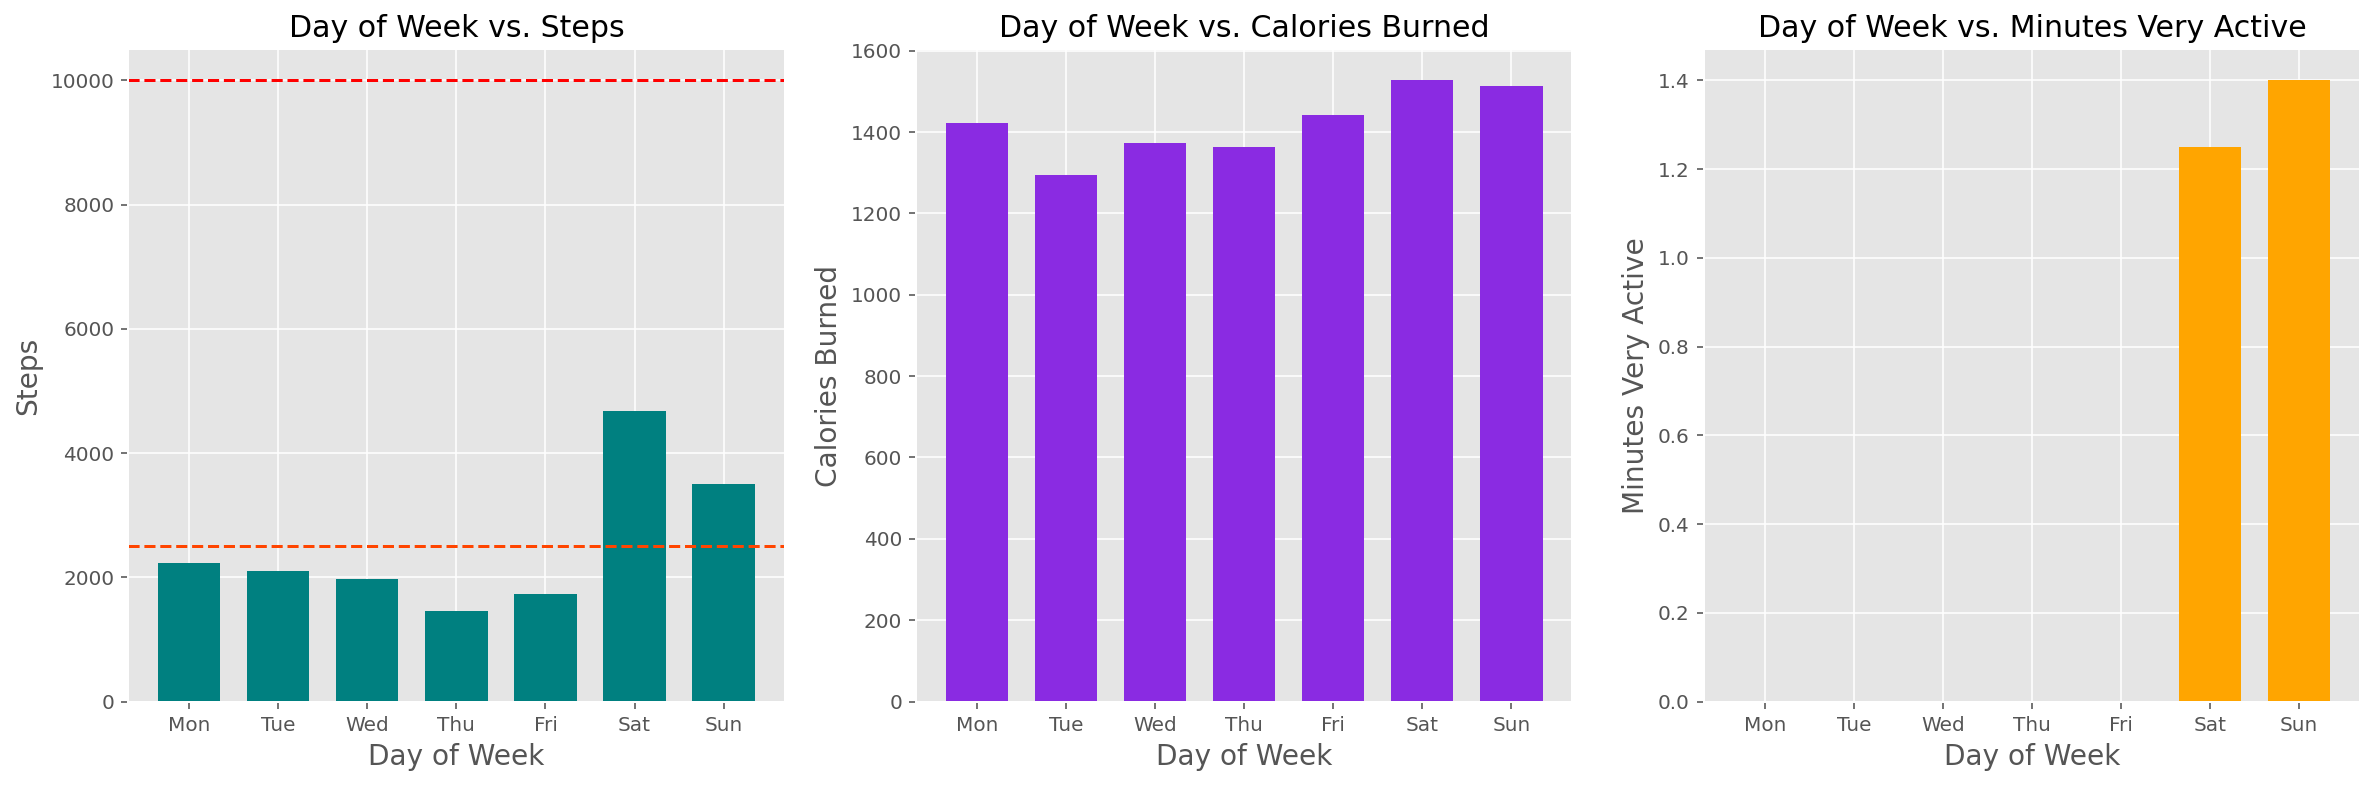

In [9]:
fig = plt.figure(figsize = (20,6))
plt.grid(True)

ax = plt.subplot(131)  
plt.bar(dayGroupedData.index, dayGroupedData['Steps'], color='teal', width = 0.7)
plt.title('Day of Week vs. Steps', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Steps', fontsize=14)
ax.axhline (2500, color="orangered", linestyle='--')
ax.axhline (10000, color="red", linestyle='--')
ax.set_xticklabels(minDayCodes)

#############

ax2 = fig.add_subplot(132)
plt.bar(dayGroupedData.index, dayGroupedData['Calories Burned'], color='blueviolet', width = 0.7)
plt.title('Day of Week vs. Calories Burned', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Calories Burned', fontsize=14)
ax2.set_xticklabels(minDayCodes)

#############

ax3 = fig.add_subplot(133)
ax3.set_xticklabels(minDayCodes)
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Very Active'], color='orange', width = 0.7)
plt.title('Day of Week vs. Minutes Very Active', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Minutes Very Active', fontsize=14)
plt.show()

Clearly seen as working from home made me not walking that much, I had kept a goal of attaining 10000 steps count each day on my Fitbit device. The graphs above suggested I am averaging about ~2500 steps per day which is a super far from my goal 😅

Saturdays and Sunday were the days where I had a minutes of very active minutes - which simply translates to active exercise because I went to grocery shop every weekends.

## 2. Sedentary minutes

Text(0.5, 1.0, '"Sedentary minutes" per day')

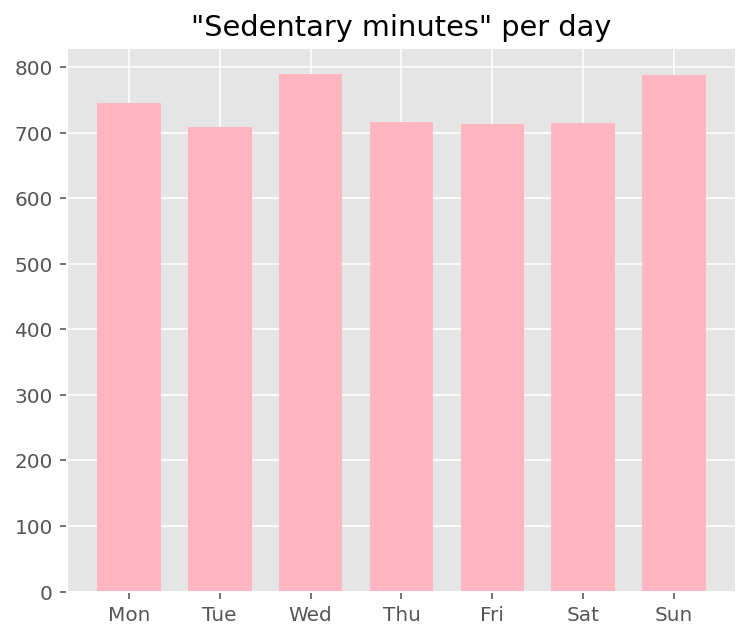

In [10]:
fig = plt.figure(figsize = (6,5))
plt.grid(True)

plt.bar(dayGroupedData.index, dayGroupedData['Minutes Sedentary'], color='lightpink', tick_label=minDayCodes[1:], width = 0.7)
plt.title('"Sedentary minutes" per day')

Sedentary minutes about ~740 minutes per day due to working from home and I like to lay down on bed while checking social media.

## 3. Calorie burn coorelation

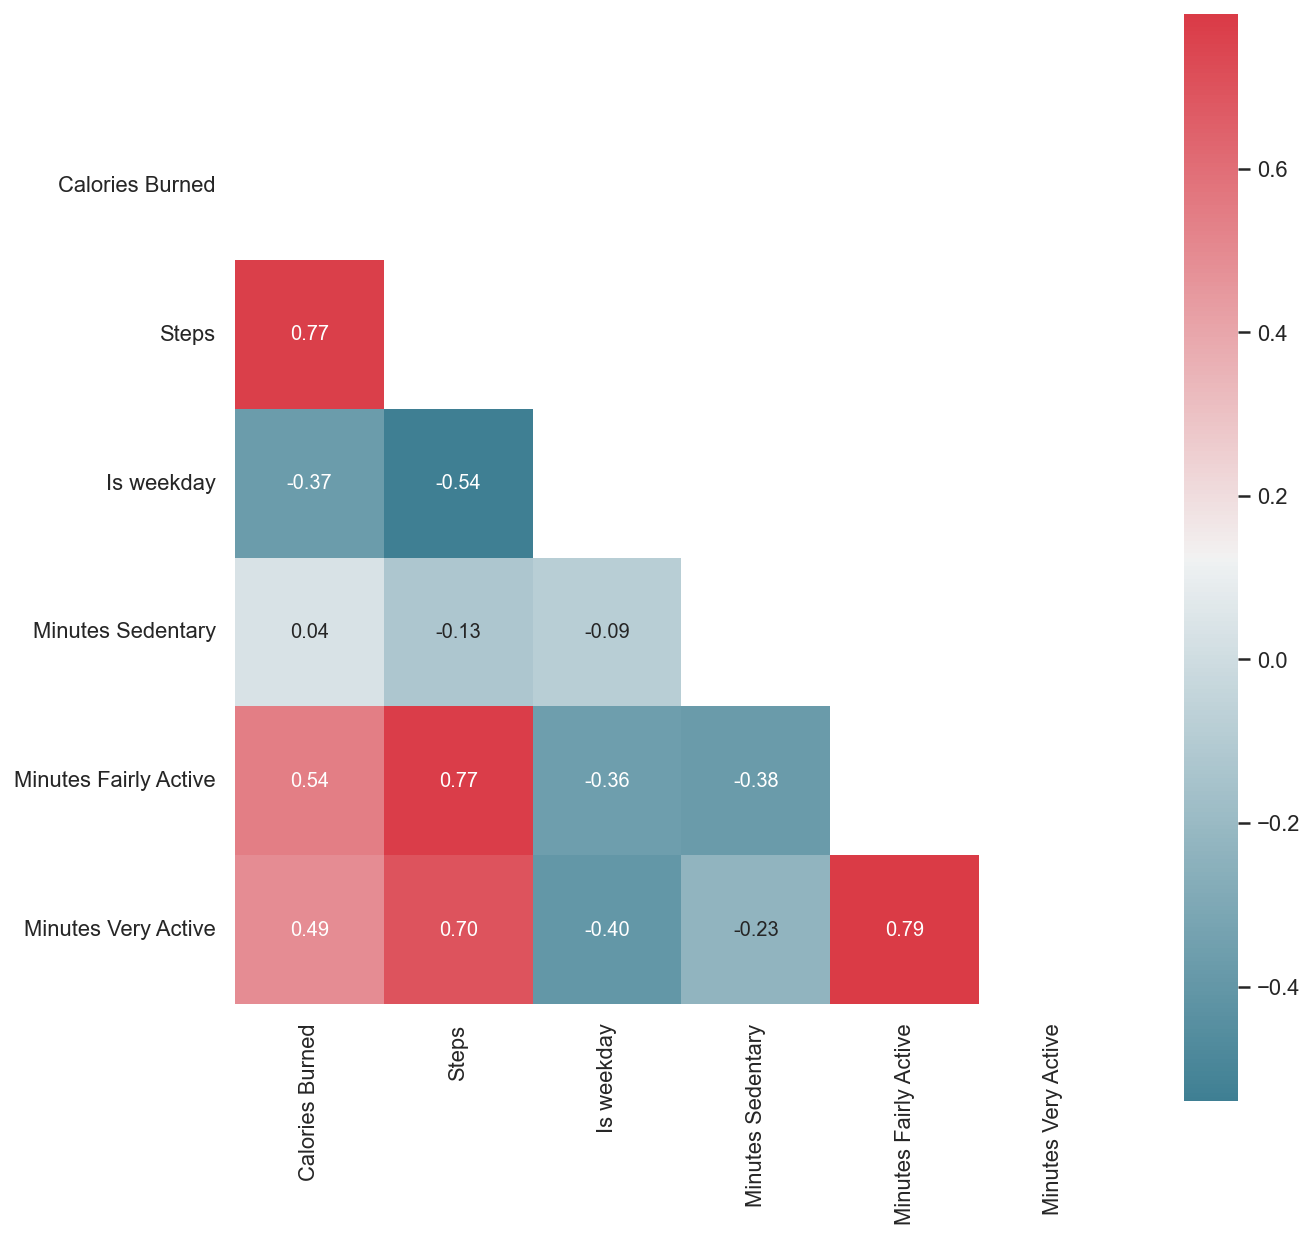

In [11]:
correlationOf = 'Calories Burned'
corrdf_calories = data[['Calories Burned','Steps', 'Is weekday', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active']]
plot_heatmap(corrdf_calories.corr(), correlationOf, '')

The calories burned is strongly related to amount of steps and active minutes. Steps have a negative correlation with Weekdays which implies that I spend more time walking on weekends.

# Sleep Analysis

Sleep is essential to helping maintain mood, memory, and cognitive performance and there is no running from it. We spend about a third of our life in sleeping. While metabolism generally slows down, all major organs and regulatory systems continue to function. Hence, it becomes important to get the most out of our sleep.

## 1. How regular is my sleeping habits?

- Am I getting the required hours of sleep? - Average sleep hours and the deviation
- Am I following a good sleep schedule? - Average sleep and wake up timings

,count,mean,std,min,25%,50%,75%,max
Time in Bed,31.0,8.819355,1.328415,6.25,8.158333,8.616667,9.475,11.65


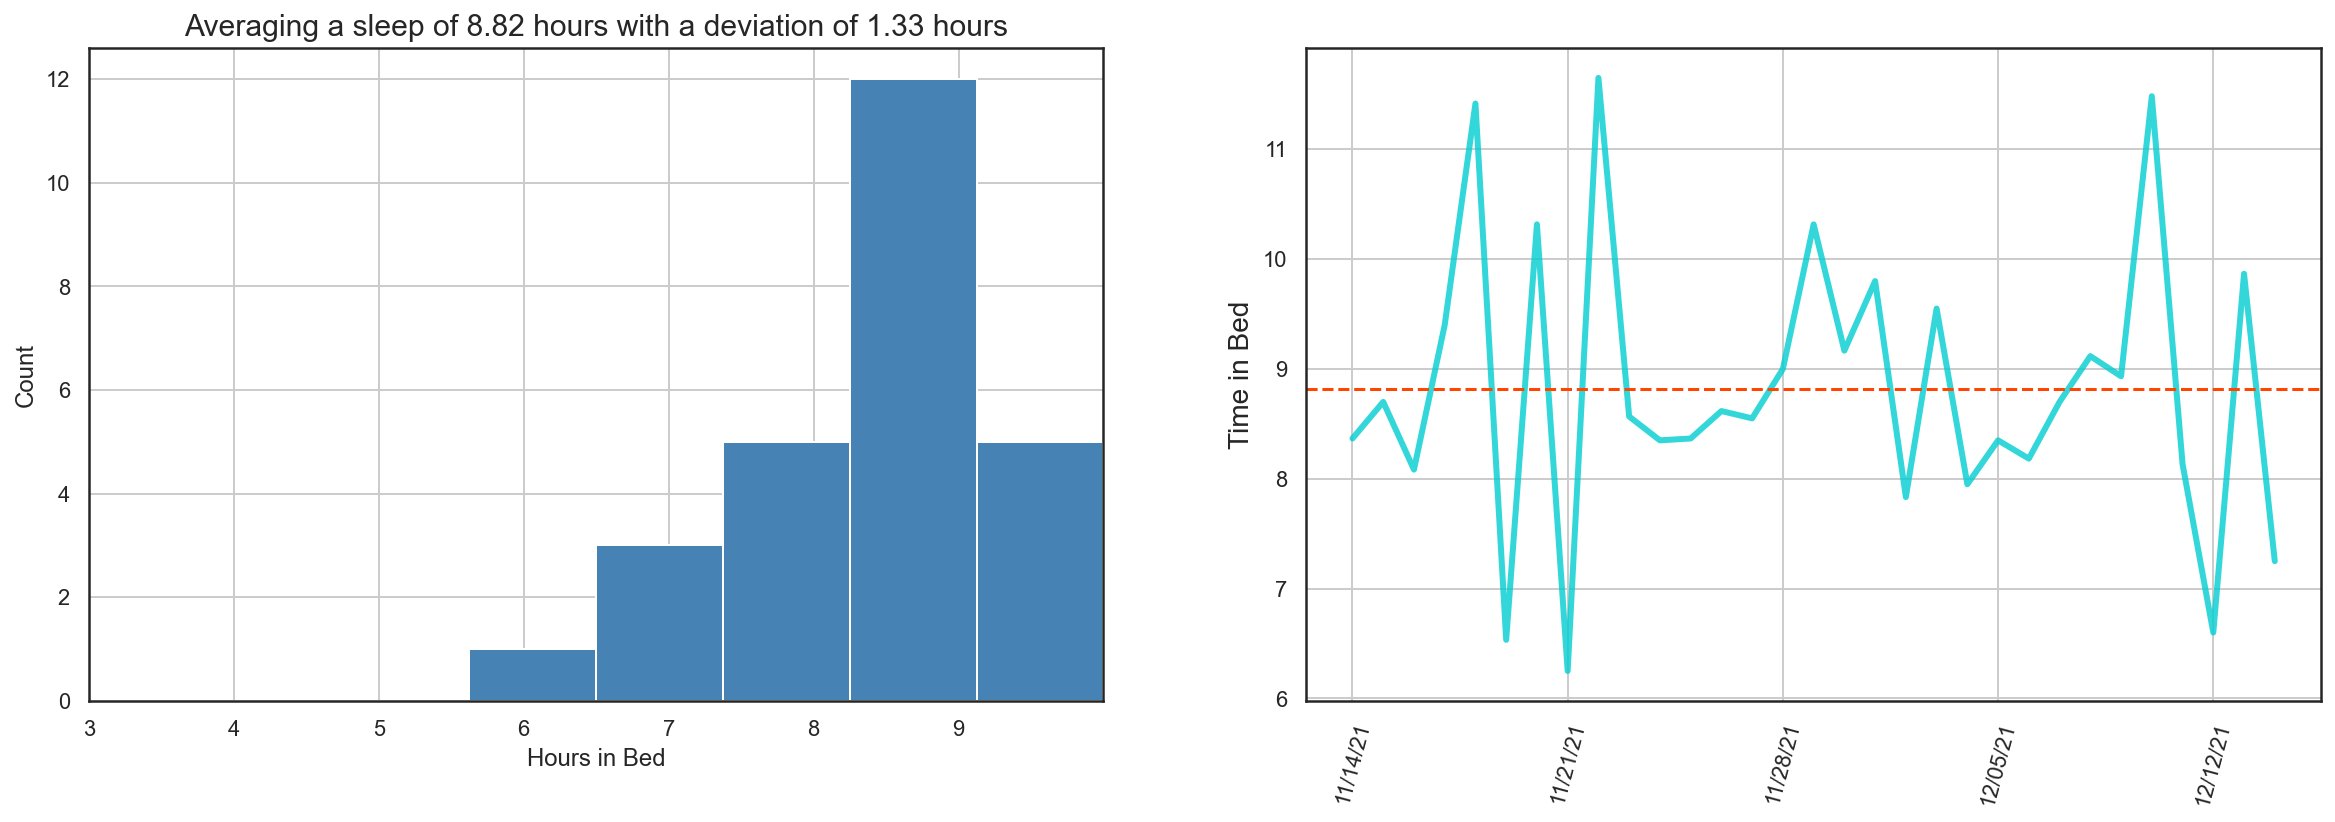

In [12]:
import matplotlib.dates as mdates

sleepDesc = pd.DataFrame(sleepData['Time in Bed']/60).describe().transpose()
avgSleepHours = round(sleepDesc.at['Time in Bed','mean'],2)
summary = 'Averaging a sleep of {} hours with a deviation of {} hours'.format(avgSleepHours, round(sleepDesc.at['Time in Bed','std'],2))
hoursInBed = sleepData['Time in Bed']/60

fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
plt.hist(hoursInBed, bins = 8, range = (3, 10), color="steelblue")
plt.xlim(3, 10)
plt.xticks(range(3, 10))
plt.xlabel('Hours in Bed')
plt.ylabel('Count');
plt.title(summary, fontsize=15)
plt.grid(True)

#############

ax2 = fig.add_subplot(122)
plt.plot(sleepData['Date'],hoursInBed, linestyle='-', 
         markersize=10, color='darkturquoise', label='% Light', linewidth=3.0, alpha=0.8)
plt.ylabel('Time in Bed', fontsize=14)
ax2.axhline(avgSleepHours, color="orangered", linestyle='--')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax2.grid(True)
plt.xticks(rotation=75)
plt.plot()
plt.grid(True)

sleepDesc

As far as behavioral data goes, this is reasonably well-behaved. Notice that this distribution does vary and is quite steep. The deviation is about an hour.

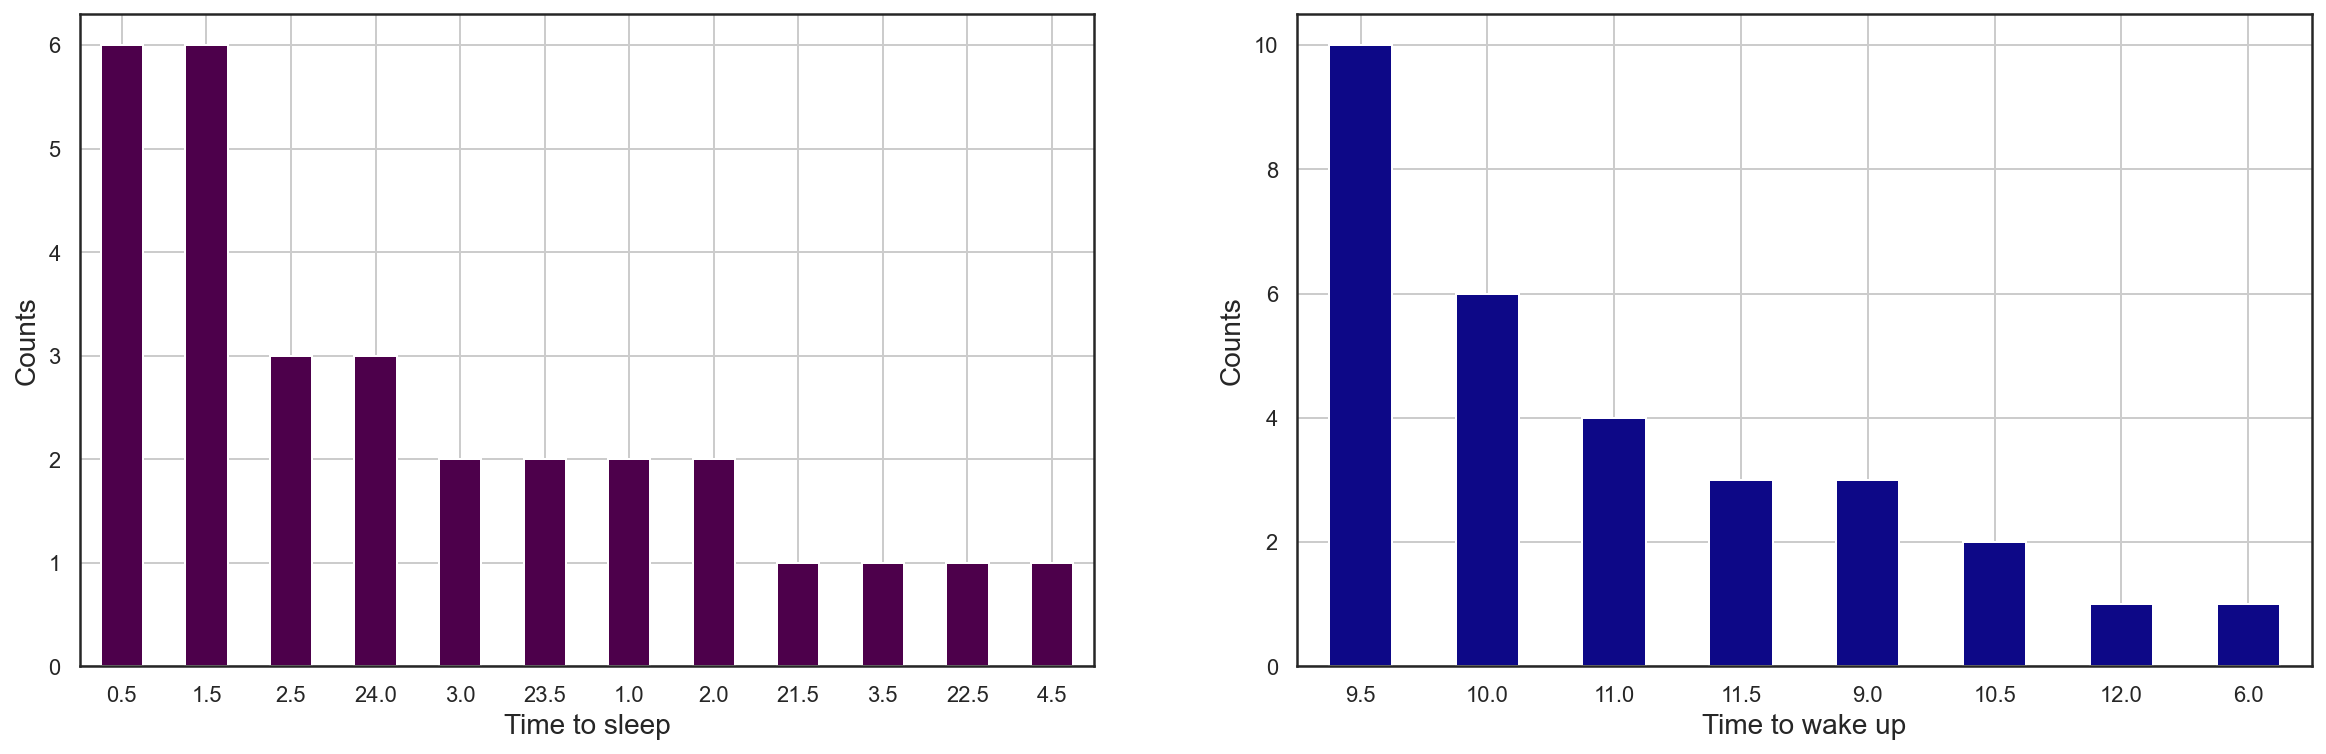

In [13]:
sleepBDF = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in Bed']]
sleepBDF['Time in Bed'] = sleepBDF['Time in Bed']/60

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))


ax = plt.subplot(121)  
pd.value_counts(sleepData['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=1)
plt.xlabel('Time to sleep', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepData['Awake Bucket']).plot.bar(cmap="plasma", alpha=1)
plt.xlabel('Time to wake up', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

I mostly sleep around 00:30 am and 01:30 am which is pretty late. And wake up around 09:30 am.

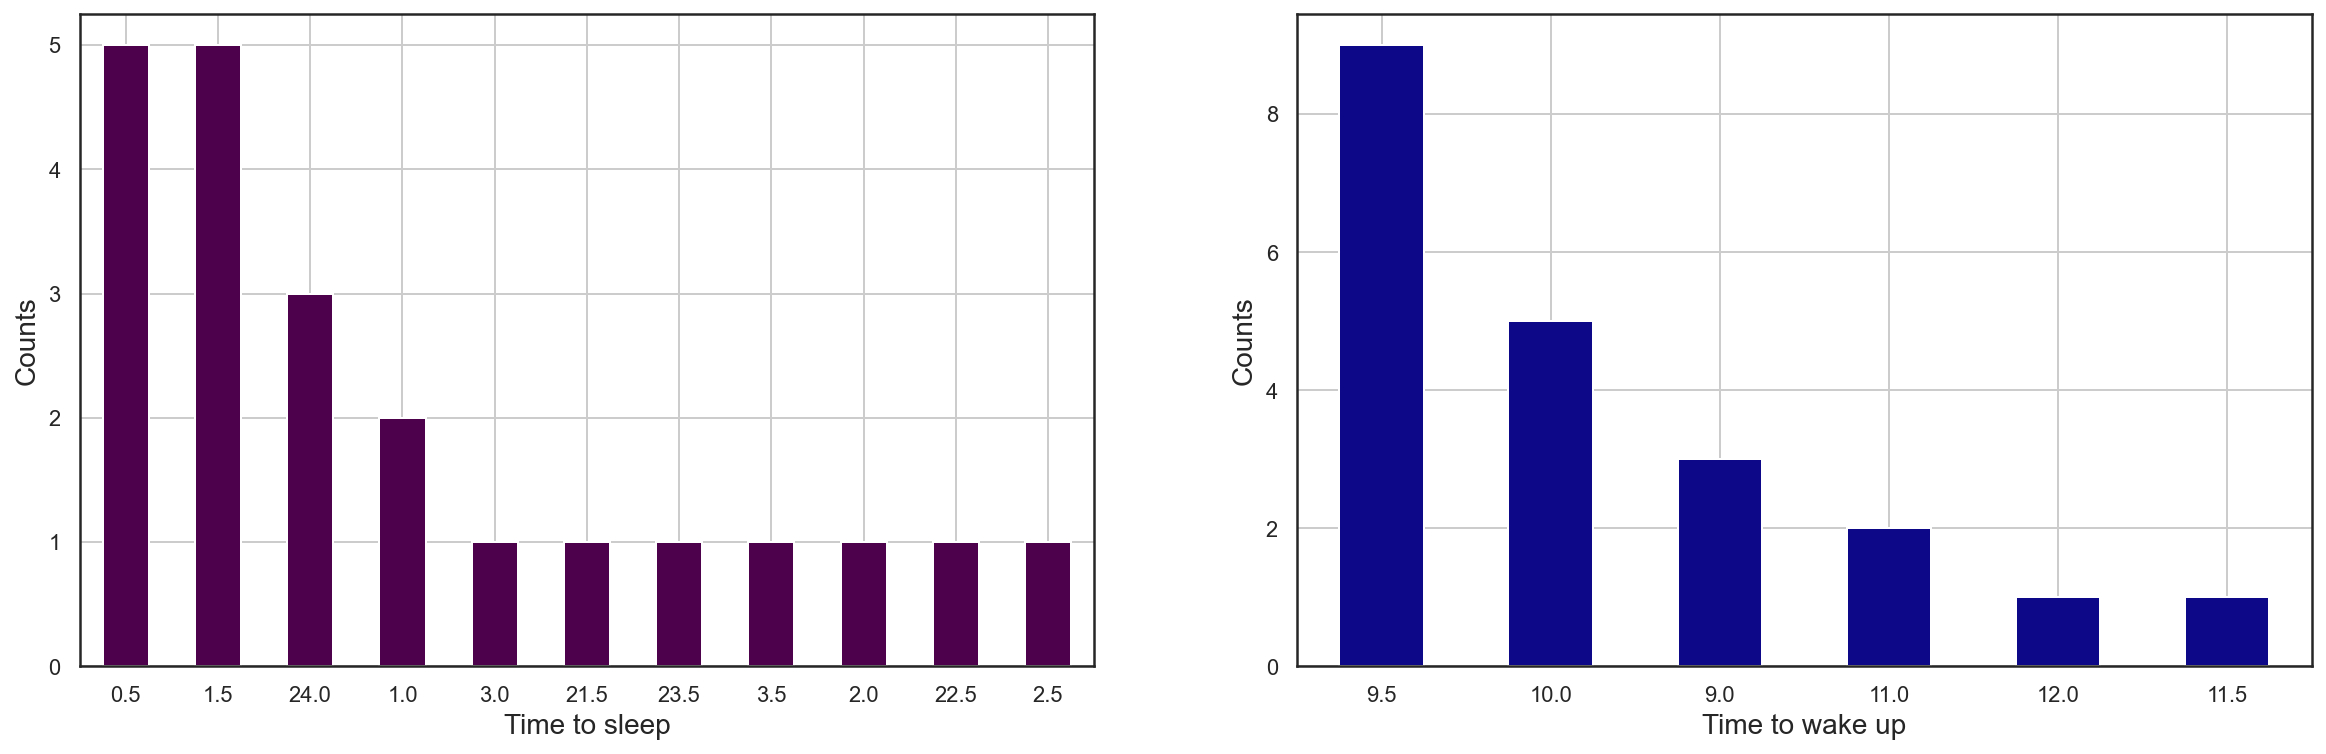

In [14]:
sleepBDF_weekday = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in Bed', 'Is weekday']]
sleepBDF_weekday['Time in Bed'] = sleepBDF_weekday['Time in Bed']/60
sleepBDF_weekday = sleepBDF_weekday[sleepBDF_weekday['Is weekday']]

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
pd.value_counts(sleepBDF_weekday['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=1)
plt.xlabel('Time to sleep', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepBDF_weekday['Awake Bucket']).plot.bar(cmap="plasma", alpha=1)
plt.xlabel('Time to wake up', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

On weekdays, I sleep around 00:30 am and 01:30 am which is pretty late. And wake up around 09:30 am.

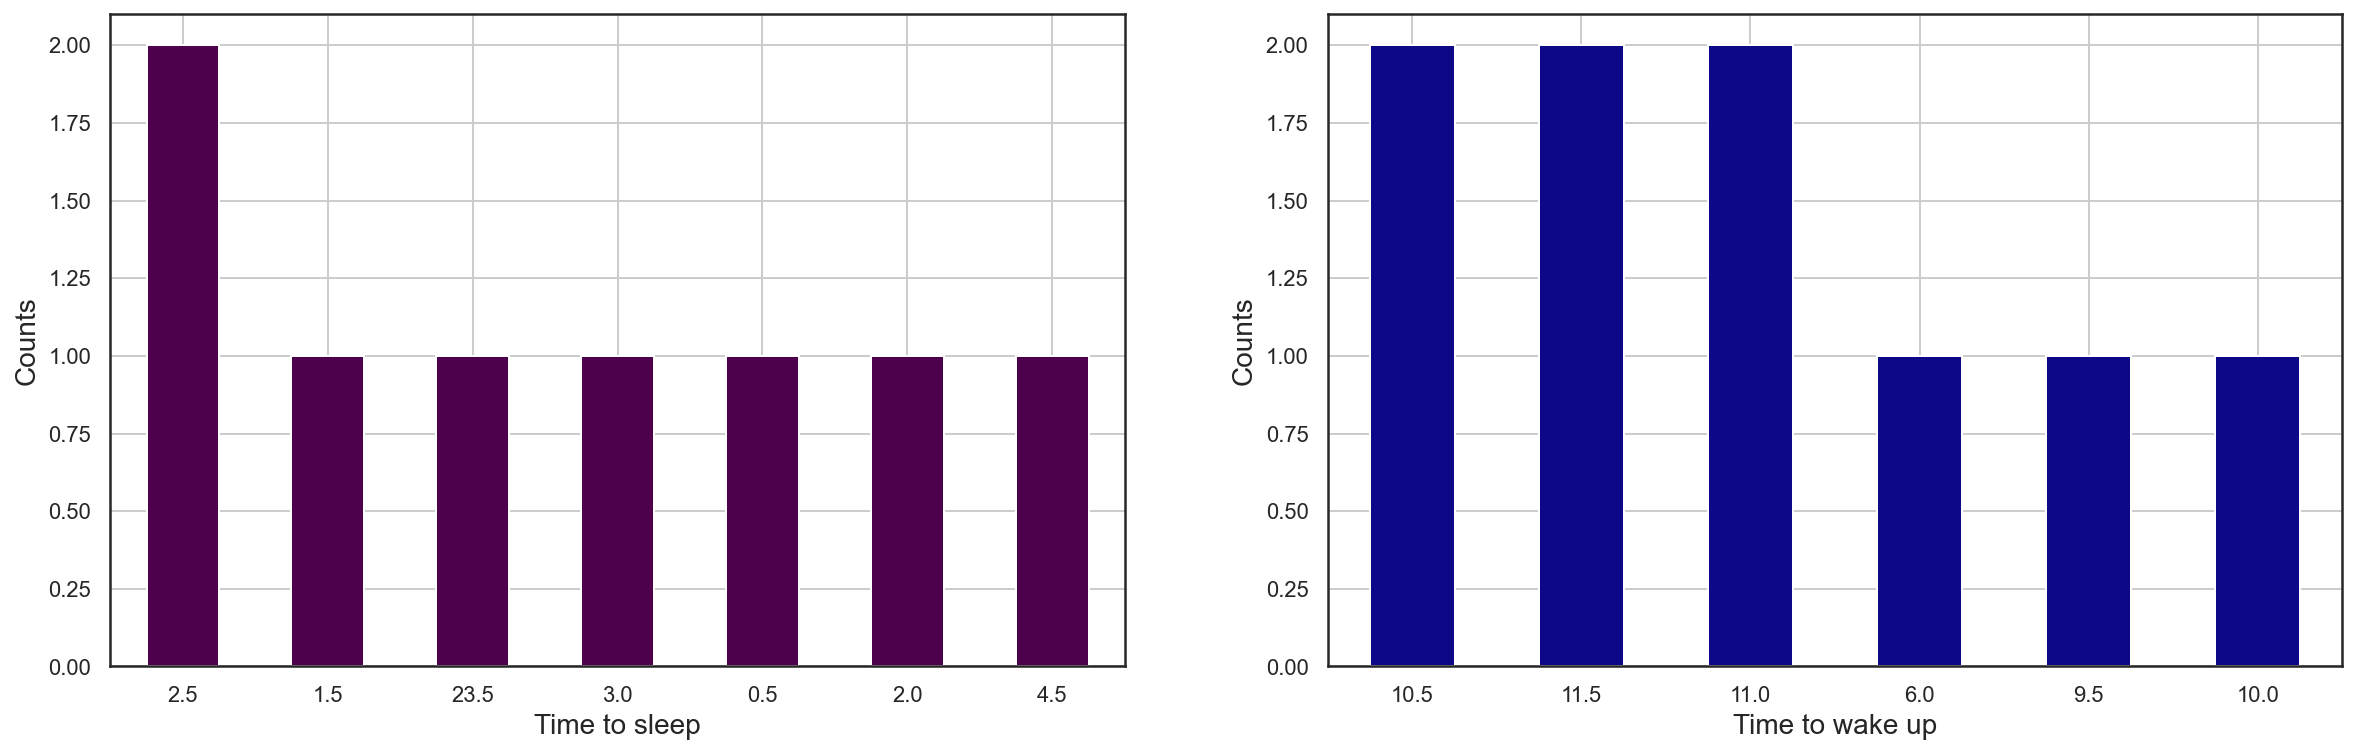

In [15]:
sleepBDF_weekend = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in Bed', 'Is weekend']]
sleepBDF_weekend['Time in Bed'] = sleepBDF_weekend['Time in Bed']/60
sleepBDF_weekend = sleepBDF_weekend[sleepBDF_weekend['Is weekend']]

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
pd.value_counts(sleepBDF_weekend['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=1)
plt.xlabel('Time to sleep', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepBDF_weekend['Awake Bucket']).plot.bar(cmap="plasma", alpha=1)
plt.xlabel('Time to wake up', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

On weekends, I sleep around 02:30 am due to movie night 🤩 👿 and wake up around 10:30 - 11:30 am.

## 2. Types of sleep

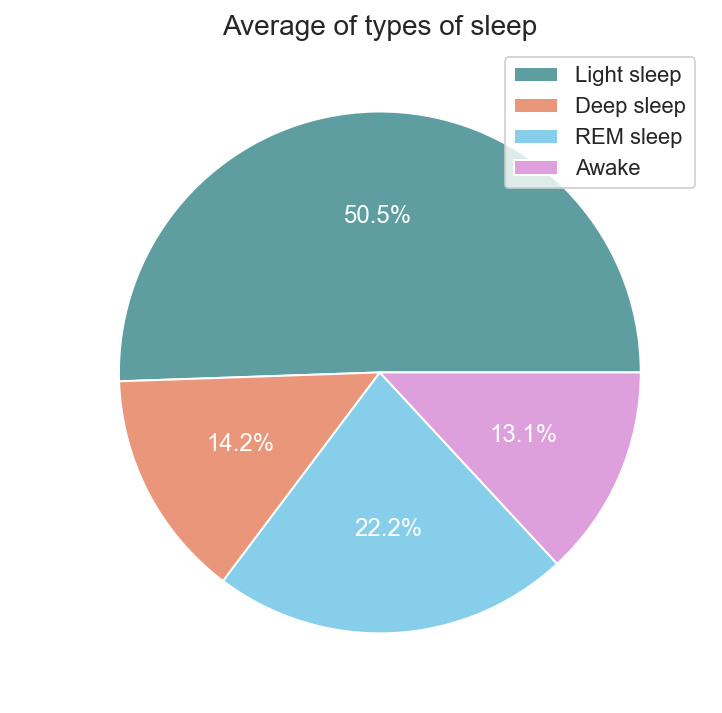

In [16]:
avgSleep = sleepData[['Minutes Light Sleep', 'Minutes Deep Sleep', 'Minutes REM Sleep', 'Minutes Awake']].mean()

fig = plt.figure(figsize = (6,6))
labels=['Light sleep', 'Deep sleep', 'REM sleep', 'Awake']
plt.pie(avgSleep, colors = ['cadetblue', 'darksalmon', 'skyblue', 'plum'], autopct='%1.1f%%', labels=labels, textprops=dict(color="w"))

# #carve the donut
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# p=plt.gcf()
# p.gca().add_artist(my_circle)

plt.title('Average of types of sleep', fontsize=14)
plt.legend()
plt.show()

The plot above shows that on an average, my body spends just about 14% in Deep sleep, 22% REM and rest in either light or being slightly awake.

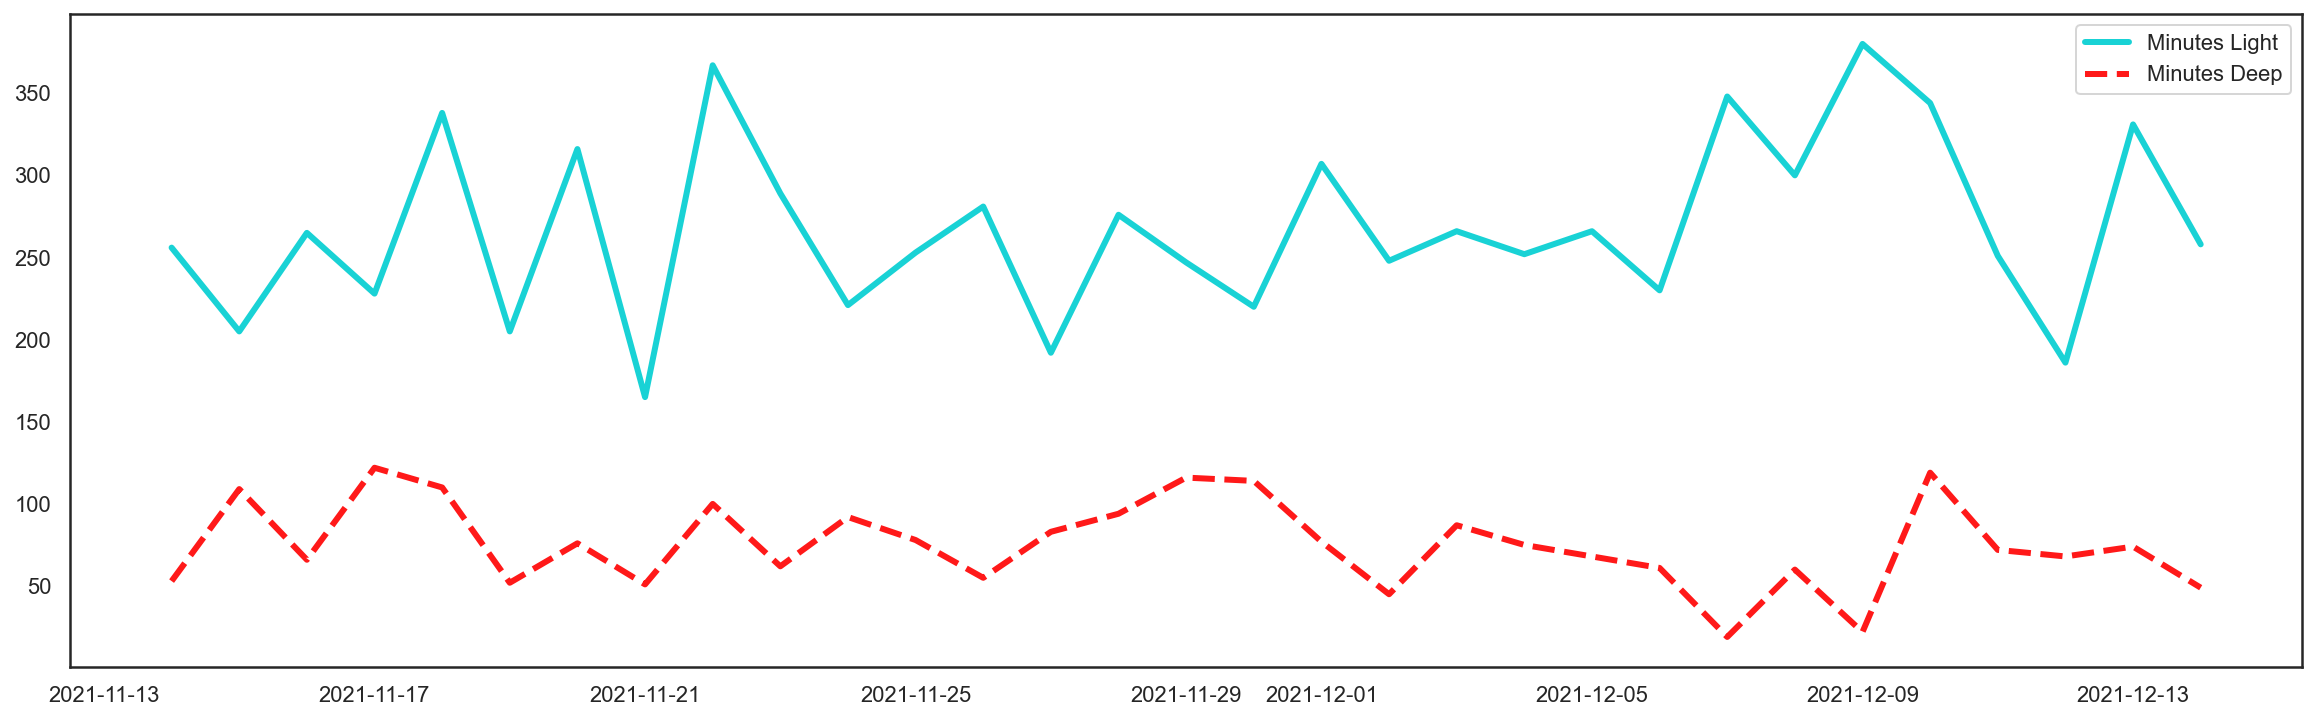

In [17]:
fig = plt.figure(figsize = (20,6))

plt.plot(sleepData['Date'],sleepData['Minutes Light Sleep'], linestyle='-', 
         markersize=10, color='darkturquoise', label='Minutes Light', linewidth=3.0, alpha=0.9)
plt.plot(sleepData['Date'],sleepData['Minutes Deep Sleep'], linestyle='--', 
         markersize=10, color='red', label='Minutes Deep', linewidth=3.0, alpha=0.9)
plt.legend()
plt.grid(False)

The datetime plot of Light and Deep sleep shows that these numbers vary a lot.

## 3. Correlation between amount of sleep and the sleep stages.

Do sleeping more will help me attain more deep or REM sleep?

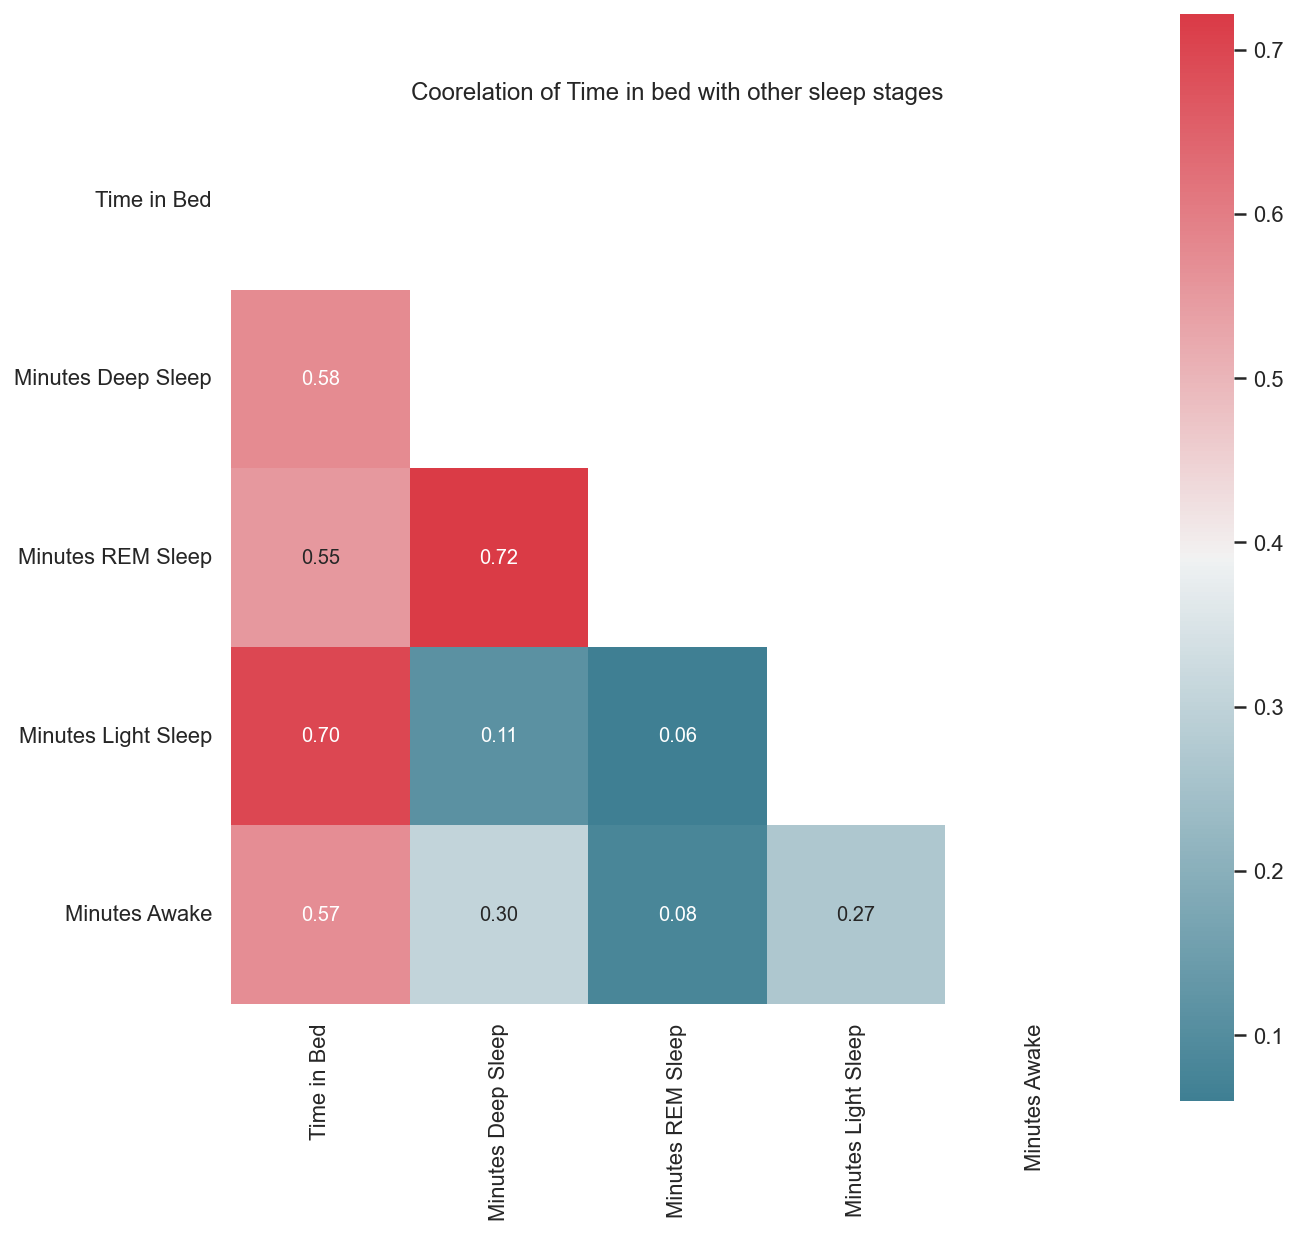

,Time in Bed,Minutes Deep Sleep,Minutes REM Sleep,Minutes Light Sleep,Minutes Awake
Time in Bed,1.000000,0.575978,0.552281,0.696585,0.569927
Minutes Deep Sleep,0.575978,1.000000,0.721687,0.112446,0.304202
Minutes REM Sleep,0.552281,0.721687,1.000000,0.059810,0.078067
Minutes Light Sleep,0.696585,0.112446,0.059810,1.000000,0.269073
Minutes Awake,0.569927,0.304202,0.078067,0.269073,1.000000


In [18]:
corrdf_sleep_types = sleepData[['Time in Bed', 'Minutes Deep Sleep', 'Minutes REM Sleep', 'Minutes Light Sleep', 'Minutes Awake']].corr().abs()
plot_heatmap(corrdf_sleep_types, correlationOf, 'Coorelation of Time in bed with other sleep stages')
corrdf_sleep_types

Notice that the "Deep sleep minutes" are not very coorelated with the time in bed. Which shows that sleepinng more doesn't necessarily guarantee a good deep sleep.

## 4. Types of Sleep based on different days

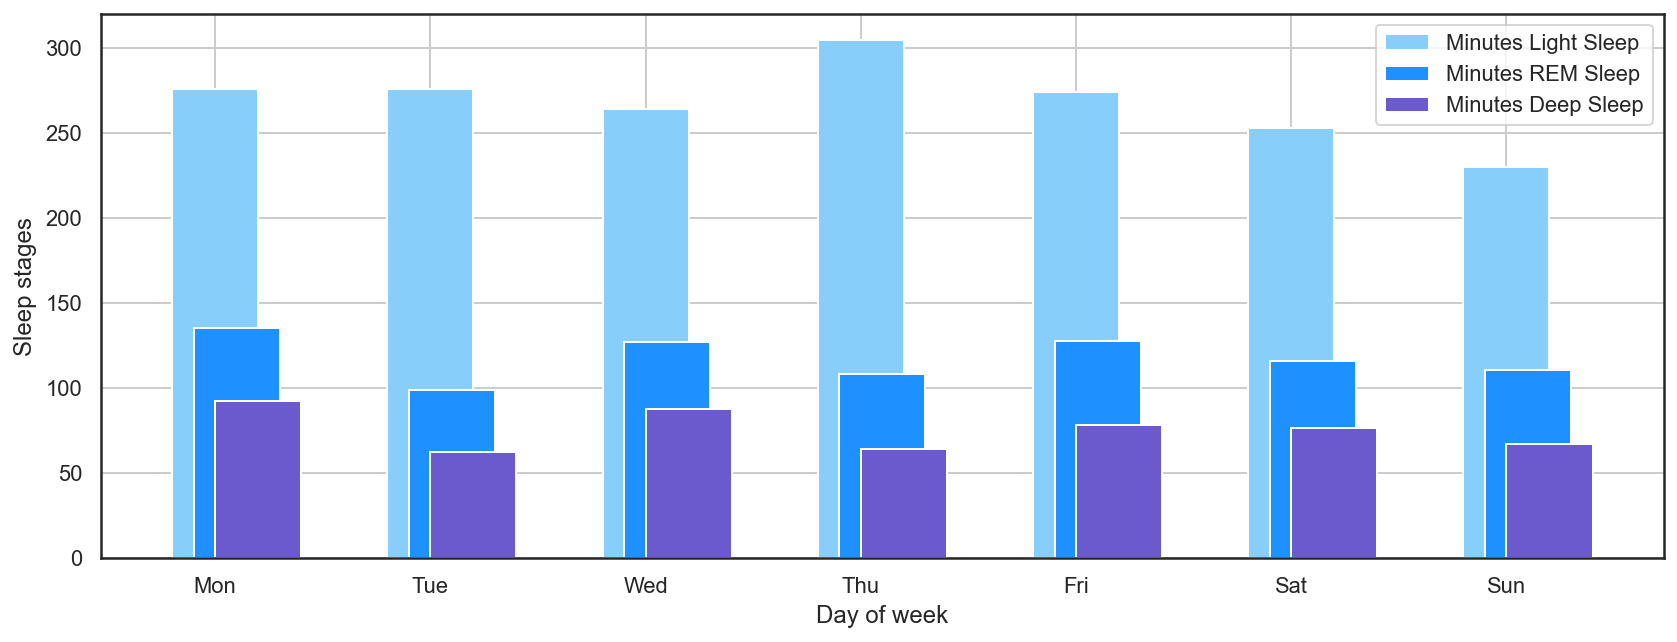

In [19]:
fig = plt.figure(figsize = (14,5))
plt.bar((dayGroupedData.index), dayGroupedData['Minutes Light Sleep'],width = 0.4, color='lightskyblue', label="Minutes Light Sleep", tick_label=minDayCodes[1:])
plt.bar((dayGroupedData.index + 0.1), dayGroupedData['Minutes REM Sleep'], width = 0.4, color='dodgerblue', label="Minutes REM Sleep")
plt.bar((dayGroupedData.index + 0.2), dayGroupedData['Minutes Deep Sleep'], width = 0.4, color='slateblue', label="Minutes Deep Sleep")
plt.xlabel('Day of week')
plt.ylabel('Sleep stages')
plt.legend()
plt.grid(True)

Let's now look at the different days of the week. I less sleep on weekends due to movies night I guess 🤔

## 5. Effect of Sleep on Weekdays vs Weekends

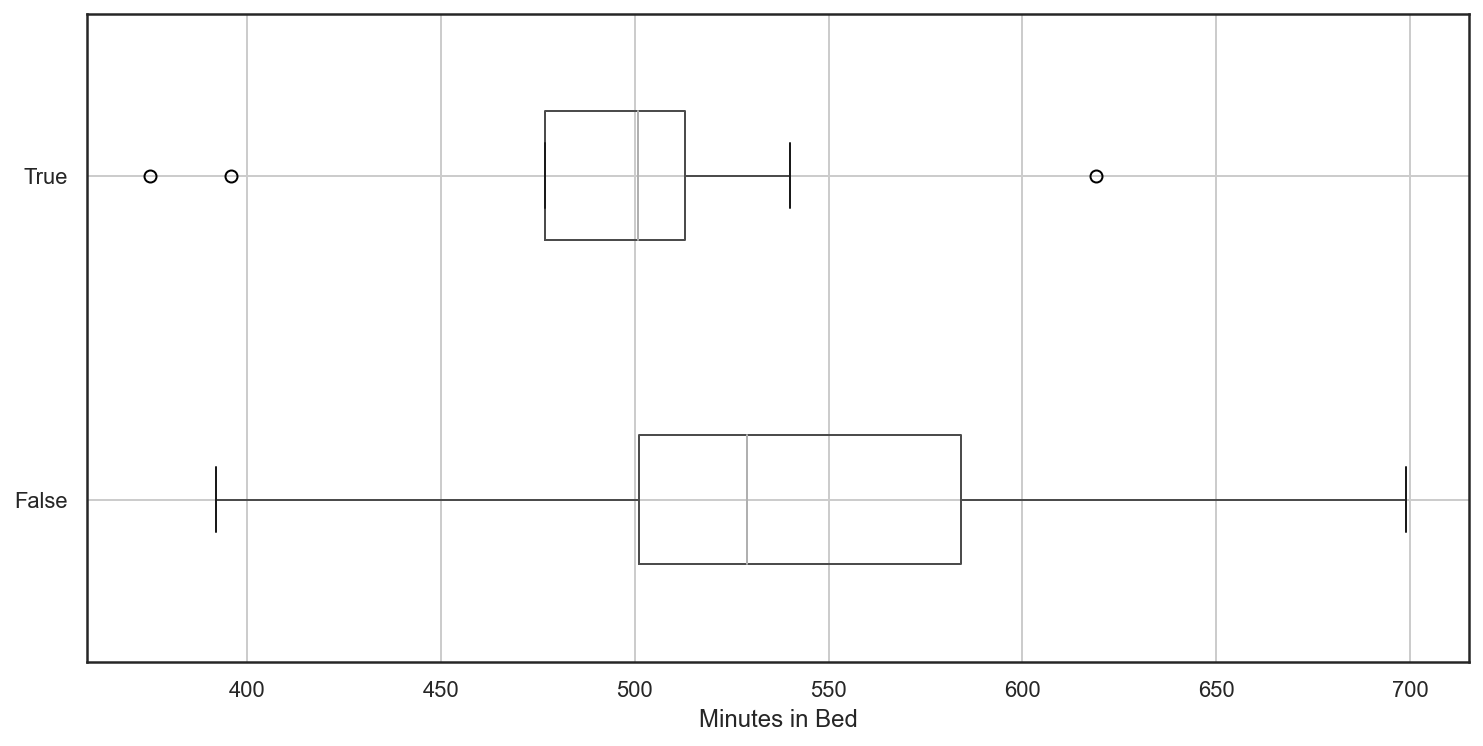

In [20]:
ax = sleepData.boxplot(column = 'Time in Bed', by = 'Is weekend', vert = False, widths = 0.4)
plt.xlabel('Minutes in Bed')
plt.suptitle('')
plt.title('')
plt.grid(True);

The above plot shows that I tend to sleep a bit more on Weekday. The upper whisker is quite high for both indicatign varying sleep times.

let's check out how does the plots vary for indivisual days of the week.

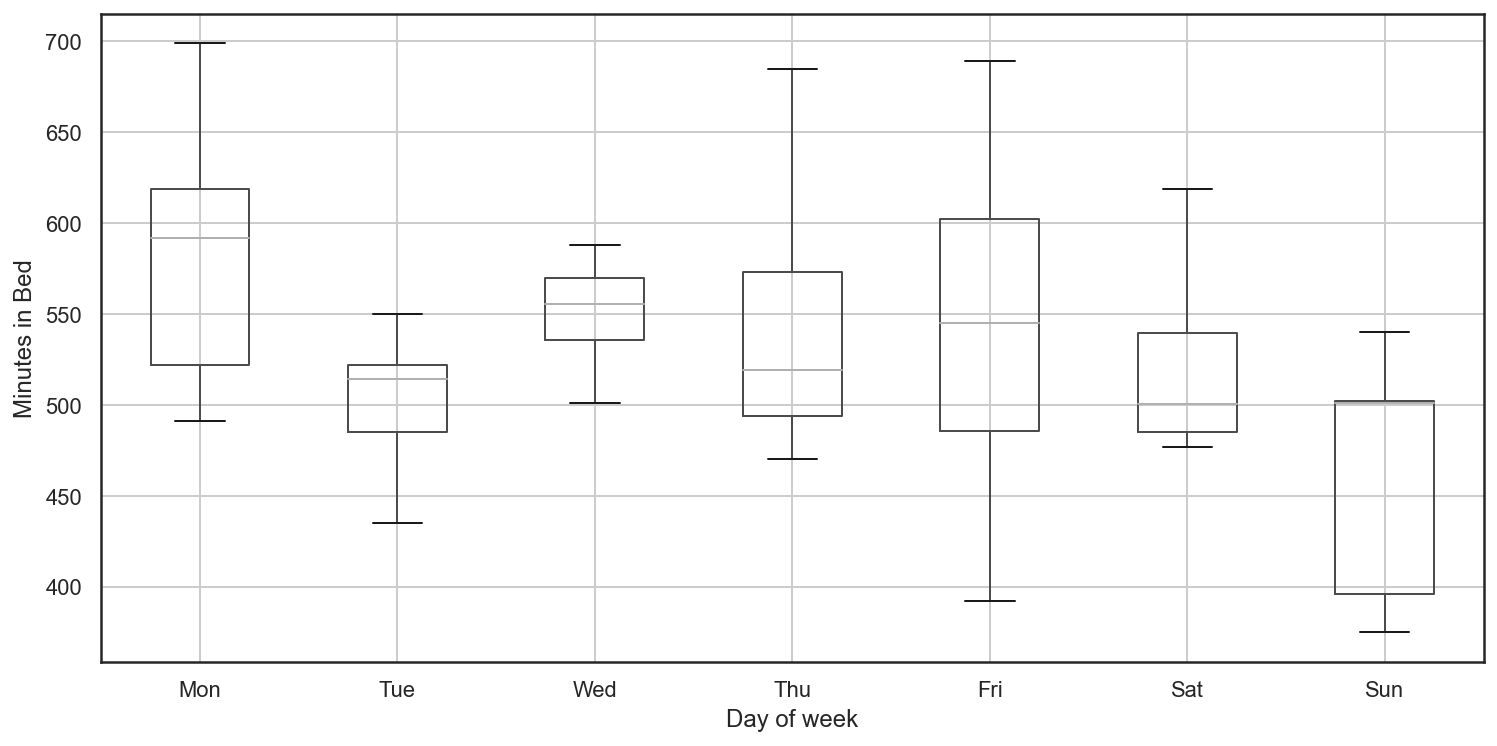

In [21]:
ax = sleepData.boxplot(column = 'Time in Bed', by = 'Day of week')
ax.set_xticklabels(minDayCodes[1:])
plt.ylabel('Minutes in Bed')
plt.suptitle('')
plt.title('')
plt.grid(True);

This plot of each day is vary a lot.

## 6. Nap Time During The Day

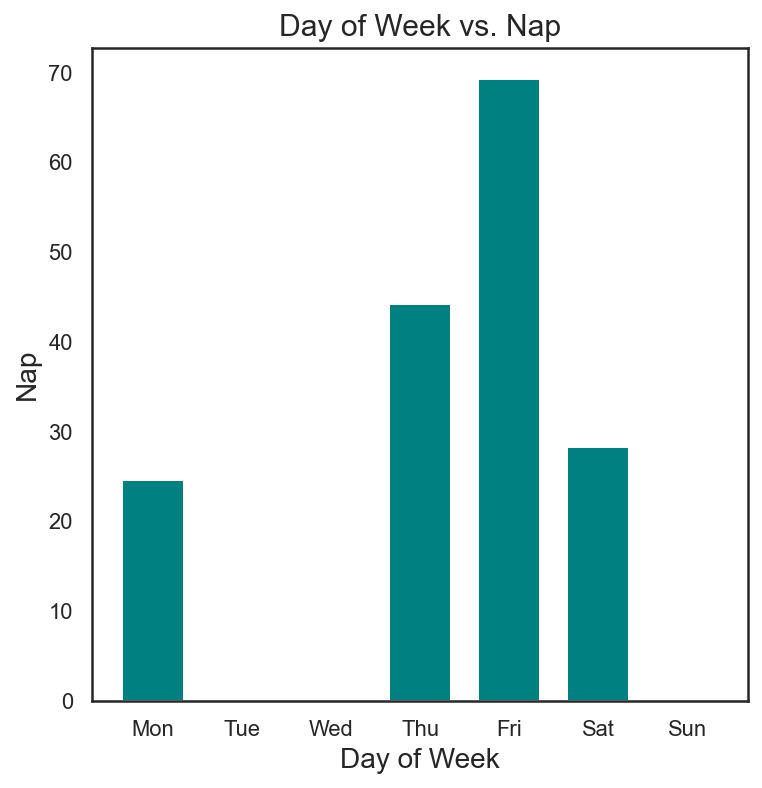

In [22]:
fig = plt.figure(figsize = (20,6))
plt.grid(True)

ax = plt.subplot(131)  
plt.bar(dayGroupedData.index, dayGroupedData['Nap'], color='teal', width = 0.7)
plt.title('Day of Week vs. Nap', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Nap', fontsize=14)
ax.set_xticklabels(minDayCodes)
plt.show()

I had a nap on Monday, Thursday, Friday and Saturday.

To find out is napping during the day will help improve active minutes?

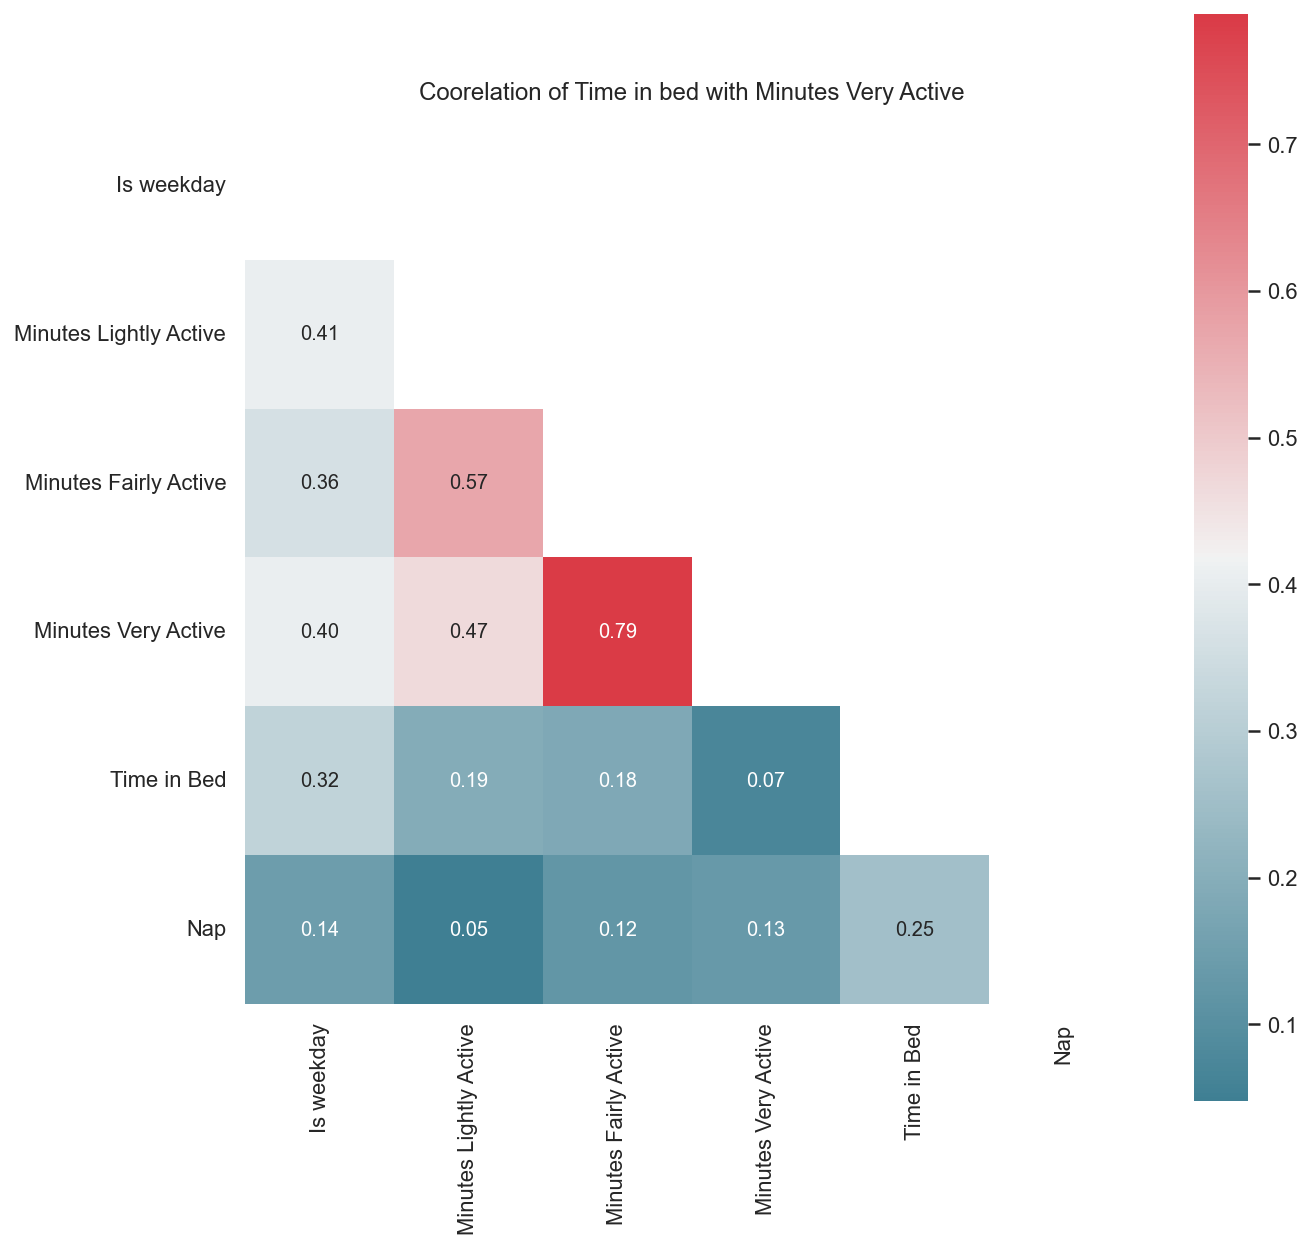

,Is weekday,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Time in Bed,Nap
Is weekday,1.000000,0.405165,0.362066,0.404624,0.318543,0.144665
Minutes Lightly Active,0.405165,1.000000,0.569230,0.466063,0.193546,0.047605
Minutes Fairly Active,0.362066,0.569230,1.000000,0.788933,0.181926,0.120158
Minutes Very Active,0.404624,0.466063,0.788933,1.000000,0.071256,0.134282
Time in Bed,0.318543,0.193546,0.181926,0.071256,1.000000,0.254357
Nap,0.144665,0.047605,0.120158,0.134282,0.254357,1.000000


In [23]:
corrdf_activity_types = sleepData[['Is weekday', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active', 'Time in Bed', 'Nap']].corr().abs()
plot_heatmap(corrdf_activity_types, correlationOf, 'Coorelation of Time in bed with Minutes Very Active')
corrdf_activity_types

Seeing that the "Nap" are not very coorelated with the "Minutes Very Active". Which shows that having a nap during the day doesn't necessarily guarantee that we will more active.